### 进化算法

In [104]:
import numpy as np
import random
import math
import pandas as pd
from random import choice
import matplotlib.pyplot as plt


In [105]:

data = pd.read_excel('./data_read/data_3.xlsx')
data = pd.read_excel('./data_read/data_3.xlsx', usecols=range(1, len(data.columns)))
data_normalized = data.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
data_mean = data.mean()
data_std = data.std()
data_dfmax = data_normalized.max()
data_dfmin = data_normalized.min()


In [106]:
data_max = list(data_dfmax)
data_min = list(data_dfmin)
x_max = data_max[:-1] 
x_min = data_min[:-1]


In [107]:
data_std

n(r／min)      575.355962
vf(mm／min)     43.943537
h(mm)           0.562221
W(mm)           2.491364
P(kW)           0.129819
dtype: float64

In [108]:
import torch.nn as nn
class Pw_Model(nn.Module):
    def __init__(self, input_dim):
        super(Pw_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B, 1) -> (B)
        return x


In [109]:
import torch
model  = torch.load('./save/data_3.pt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)



Pw_Model(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [110]:
data_normalized


,n(r／min),vf(mm／min),h(mm),W(mm),P(kW)
0,-1.414214,-0.92582,1.507557,1.224745,-0.921885
1,-0.707107,-0.92582,1.507557,1.224745,-0.373455
2,0.000000,-0.92582,1.507557,1.224745,0.410017
3,0.707107,-0.92582,1.507557,1.224745,1.115141
4,1.414214,-0.92582,1.507557,1.224745,1.898612
5,-1.414214,-1.38873,0.603023,0.000000,-1.235273
6,-0.707107,-1.38873,0.603023,0.000000,-0.921885
7,0.000000,-1.38873,0.603023,0.000000,-0.138413
8,0.707107,-1.38873,0.603023,0.000000,0.645058
9,1.414214,-1.38873,0.603023,0.000000,1.506877


In [111]:
x_input = [-1.414214,-0.92582,1.507557,1.224745]

最优解： [-1.4142102139739, 1.3887222733137794, -1.204861144681439, -1.224689483936998]
最优适应度： -1.5561857


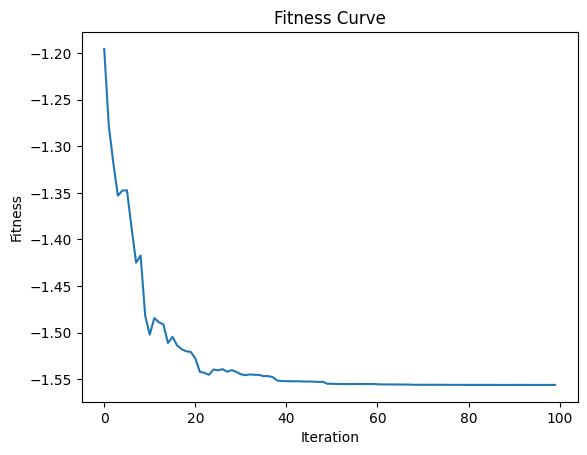

In [121]:
import random
import matplotlib.pyplot as plt

# 自定义拟合函数
def fitness_function(x):
    x_input = torch.Tensor([x]).to(device)
    f = model(x_input).cpu().detach().numpy()[0]
    return f

# 蜜蜂类
class Bee:
    def __init__(self, position):
        self.position = position
        self.fitness = fitness_function(position)

# 蜜蜂群类
class BeeColony:
    def __init__(self, n_bees, n_dimensions, x_min, x_max):
        self.bees = []
        self.n_bees = n_bees
        self.n_dimensions = n_dimensions
        self.x_min = x_min
        self.x_max = x_max
        self.best_fitnesses = []  # 存储每次迭代的最佳适应度值

        # 初始化蜜蜂群
        for _ in range(n_bees):
            position = [random.uniform(x_min[i], x_max[i]) for i in range(n_dimensions)]
            self.bees.append(Bee(position))

    # 获取最优解
    def get_best_solution(self):
        best_bee = min(self.bees, key=lambda bee: bee.fitness)
        return best_bee.position, best_bee.fitness

    # 更新蜜蜂位置
    def update_bees(self):
        for bee in self.bees:
            best_neighbor = self.get_best_neighbor(bee)
            new_position = [bee.position[i] + random.uniform(-1, 1) * (bee.position[i] - best_neighbor.position[i])
                            for i in range(self.n_dimensions)]

            # 确保新位置在边界内
            new_position = [min(max(new_position[i], self.x_min[i]), self.x_max[i]) for i in range(self.n_dimensions)]

            # 更新蜜蜂的位置和适应度
            bee.position = new_position
            bee.fitness = fitness_function(new_position)

        # 存储最佳适应度值
        self.best_fitnesses.append(self.get_best_solution()[1])

    # 获取最佳邻居蜜蜂
    def get_best_neighbor(self, bee):
        neighbors = [other_bee for other_bee in self.bees if other_bee != bee]
        best_neighbor = min(neighbors, key=lambda neighbor: neighbor.fitness)
        return best_neighbor

    # 绘制适应度曲线
    def plot_fitness_curve(self):
        plt.plot(range(len(self.best_fitnesses)), self.best_fitnesses)
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.title('Fitness Curve')
        plt.show()

# 参数设置
n_bees = 40
n_dimensions = 4
n_iterations = 100

# 创建蜜蜂群实例
colony = BeeColony(n_bees, n_dimensions, x_min, x_max)

# 优化迭代
for _ in range(n_iterations):
    colony.update_bees()

# 获取最优解
best_position, best_fitness = colony.get_best_solution()

# 输出结果
print("最优解：", best_position)
print("最优适应度：", best_fitness)


# 绘制适应度曲线
colony.plot_fitness_curve()